# 2. Extracting the Obesity Signature
This notebook is the second one of a series that show how to extract a **robust** transcriptomic signature of obesity from four adipose-tissue data sets or **batches**. The series is sctructured as follows:


1. [Two-step SVD-filtering to remove batch-effects](1. Two-step SVD-filtering to remove batch effects.ipynb)  
2. [**Extracting the Obesity Signature**](#2.-Extracting-the-Obesity-Signature)  
    2.1 [Load gene-expression data for batches 1-4](#2.1-Load-gene-expression-data-for-batches-1-4)  
    2.2 [Compute first principal component](#2.2-Compute-first-principal-component)  
    2.3 [Set a statistical significance threshold](#2.3-Set-a-statistical-significance-threshold)  
    2.4 [Plot signature](#2.4-Plot-signature)  
    2.5 [Save signature](#2.5-Save-signature)  
3. [The Obesity Signature correlates with Body Mass Index](3. The Obesity Signature correlates with Body Mass Index.ipynb)  
4. [Identifying deregulated pathways](4. Identifying deregulated pathways.ipynb)
5. [Overview of genes in the signature](5. Overview of genes in the signature.ipynb)  

    

In [1]:
%reset -f
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

import copy
%load_ext watermark
%watermark -a "Francesc Font-Clos" -d -t -v -m -p numpy,pandas,scikit-learn,matplotlib,seaborn,scipy

Francesc Font-Clos 06/12/2017 12:39:22 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
pandas 0.20.1
scikit-learn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1
scipy 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


### 2.1 Load gene-expression data for batches 1-4
Remember that have already removed batch-effects [in this notebook](1. Two-step SVD-filtering to remove batch 
effects.ipynb) (you might need to run it before proceeding). So we just load the file we saved, which corresponds to the gene expression data of batches 1 to 4.

In [2]:
geno = pd.read_pickle("../output/batches1-4_merged/batch1234_geno.p")
pheno = pd.read_pickle("../output/batches1-4_merged/batch1234_pheno.p")

### 2.2 Compute first principal component
We compute the first principal component of the genotype dataframe. We also load GeneSymbol annotations.

In [3]:
v = (PCA(whiten=True,n_components=1).fit(geno)).components_[0]
v_df = pd.DataFrame(columns=["coef","abs_coef"],index = geno.columns)
v_df["coef"] = v
v_df["abs_coef"] = np.abs(v)
v_df.sort_values(by="abs_coef",ascending=False,inplace=True)
v_df.drop("abs_coef",axis=1,inplace=True)

In [5]:
hugo_df = pd.read_table("../data/gene_dictionaries/HUGO_official_list_20160613.txt")
entrez_to_genesymb = dict(hugo_df[["Entrez Gene ID","Approved Symbol"]].astype(unicode).applymap(lambda x:x.split(".")[0]).values)

In [6]:
v_df["GeneSymb"] = v_df.index.map(lambda x:entrez_to_genesymb[x] if x in entrez_to_genesymb.keys() else "???")
v_df.index.name = "Entrez"
v_df.set_index("GeneSymb",append=True,inplace=True)

So now we have a dataframe with genes in the index and the coefficients of the first principal component of batch1-5 as the only column. We have actually sorted the genes by absolute value of coefficient:

In [7]:
v_df.head()

,,coef
Entrez,GeneSymb,
1278,COL1A2,-0.131415
80763,SPX,0.126198
761,CA3,0.088910
219348,PLAC9,-0.074152
25975,EGFL6,-0.073139


### 2.3 Set a statistical significance threshold
The first principal component of the gene-expression data can be thought of as a direction in gene-space. To set a threshold for statistical significance, we compare the coefficients of the score with those of a random direction in this same space. 

A random direction in a space of dimension $N$ has standard Gaussian coefficients, see [Muller,1959](http://dl.acm.org/citation.cfm?id=377946). If the norm of our signature vector equals one, then the coefficients of a random direction of the same norm must have variance $1/N$, and thus the distribution of the coefficients of a random direction are Gaussians with standard deviation $\sigma = 1/\sqrt{N}$.

We then decide to set a threshold of $5\sigma$, that is, **we keep only those coefficients that are boeyond 5 sigma's** of what we would expect at random.

In [8]:
N = geno.shape[1]
sigma = 1/np.sqrt(N)

There are only 38 genes above our $5\sigma$ threshold. We discard the rest:

In [9]:
idx = np.abs(v_df.coef)>5*sigma
print "genes beyond threshold:",idx.sum()

genes beyond threshold: 38


In [10]:
signature = v_df.loc[idx]

### 2.4 Plot signature
Here we reproduce Figure 1d in the manuscript

In [11]:
v_df["abscoef"] = v_df["coef"].apply(np.abs)

In [12]:
# do an ensemble of fake signatures
tmp = np.array([sorted(np.abs(np.random.normal(size=v_df.shape[0])/np.sqrt(v_df.shape[0]))) for x in range(100)])
m=tmp.mean(axis=0)
s=tmp.std(axis=0)

In [13]:
labelsize=16  # fontsize of x,y labels
title_size=18  # fontsize of the title       
ticks_size=14  # fontsize of numbers in x,y ticks
latex_size=18  # fontsize of latex-rendered pval, corr_coef annotations

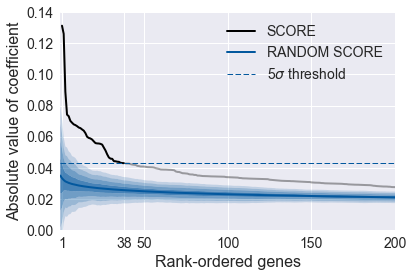

In [14]:
plt.figure(figsize=(6,4))

# internal parameters
t = range(1,N+1)
Ng = 2000
mycolor = "#03589E"
M=20
K2=5

# MAIN PLOT
plt.plot((t[:38]),v_df["abscoef"].values[:38],color="black",linestyle="-",linewidth="2",label="SCORE")
plt.plot((t[38:]),v_df["abscoef"].values[38:],color="black",alpha=0.35,linestyle="-",linewidth="2")

# SHADOWS
for j in [-1,1]:
    for K in range(0,M,5):
        plt.fill_between(range(Ng),(m+j*(K)*s)[::-1][:Ng],(m+j*(K+5)*s)[::-1][:Ng],
                         color=mycolor,linewidth=0,alpha=0.7*(M-K)/M)

# RANDOM SIGNATURE
plt.plot((m)[::-1][:Ng],color=mycolor,linestyle="-",linewidth=2,label="RANDOM SCORE")

# 5-SIGMA THRESHOLD
plt.axhline(K2/np.sqrt(v_df.shape[0]),linewidth=1,color=mycolor,linestyle="--",label="%d$\sigma$ threshold" %K2,)

# AXIS
plt.ylim([0,.14])
plt.xlim([0,200])
plt.xlabel("Rank-ordered genes",size=labelsize)
plt.ylabel("Absolute value of coefficient",size=labelsize)
plt.xticks([1,38,50,100,150,200],size=ticks_size)
plt.yticks(size=ticks_size)
plt.legend(fontsize=14)

plt.savefig("../output/figures/Figure1d.pdf")
plt.show()

### 2.5 Save signature
We save the signature in pickled and CSV form, as well as a list of all the genes in the final gene-expression matrix. These are known as the **background** genes, and must be used to correctly identify overrepresented gene sets.

In [15]:
signature.to_csv("../output/signature/signature.csv")
signature.to_pickle("../output/signature/signature.p")

In [16]:
np.savetxt("../output/batches1-4_merged/background_genes.txt",v_df.index.get_level_values(0).values,fmt="%s")

In [18]:
oldgeno = pd.read_pickle("/Users/fran/Documents/batch1234_geno.p")

In [20]:
oldgeno.iloc[0,0]

-41.887041218417139

In [21]:
geno.iloc[0,0]

-41.887041218422667

In [24]:
diffs = geno-oldgeno

In [25]:
diffs.max()

10           2.468425e-11
100          1.648459e-12
1000         5.471179e-13
10000        3.268497e-13
10001        2.167155e-13
10002        2.842171e-13
10003        2.131628e-13
10004        2.202682e-13
10005        2.344791e-13
10007        2.131628e-13
10008        1.918465e-13
1001         1.705303e-13
10010        1.989520e-13
10011        1.065814e-13
100127950    7.105427e-14
100128288    3.268497e-13
100128327    2.842171e-13
100128653    1.065814e-13
100128751    5.684342e-14
100128927    1.492140e-13
100128988    1.918465e-13
100129271    1.705303e-13
100129476    8.526513e-14
100129482    1.207923e-13
10013        8.526513e-14
100130428    7.815970e-14
100130449    1.065814e-13
100130613    9.947598e-14
100130717    6.394885e-14
100130889    1.207923e-13
                 ...     
9958         2.842171e-14
996          3.552714e-14
9960         3.552714e-14
9961         1.421085e-14
9962         2.131628e-14
9963         3.552714e-14
9965         2.842171e-14
9967        